<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_WDM_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of coherent WDM transmission

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, pnorm
from optic.models import phaseNoise, pdmCoherentReceiver

try:
    from optic.modelsGPU import manakovSSF, manakovDBP
except:
    from optic.models import manakovSSF

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power, calcEVM
from optic.plot import pconst, plotPSD

import scipy.constants as const

import logging as logg
logg.basicConfig(level=logg.WARNING, format='%(message)s', force=True)

from copy import deepcopy
from tqdm.notebook import tqdm

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
figsize(10, 3)

In [5]:
%load_ext autoreload
%autoreload 2
#%load_ext line_profiler


## Transmitter

**Polarization multiplexed WDM signal generation**

In [6]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 64           # order of the modulation format
paramTx.Rs  = 32e9         # symbol rate [baud]
paramTx.SpS = 16           # samples per symbol
paramTx.pulse = 'rrc'      # pulse shaping filter
paramTx.Ntaps = 2*4096     # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01    # RRC rolloff
paramTx.Pch_dBm = 0        # power per WDM channel [dBm]
paramTx.Nch     = 11       # number of WDM channels
paramTx.Fc      = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.lw      = 100e3    # laser linewidth in Hz
paramTx.freqSpac = 37.5e9  # WDM grid spacing
paramTx.Nmodes = 2         # number of signal modes [2 for polarization multiplexed signals]
paramTx.Nbits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/11 [00:00<?, ?it/s]

**Nonlinear fiber propagation with the split-step Fourier method**

In [7]:
# optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 700     # total link distance [km]
paramCh.Lspan  = 50      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift?
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.prgsBar = True   # show progress bar?
#paramCh.saveSpanN = [1, 5, 9, 14]
Fs = paramTx.Rs*paramTx.SpS # sampling rate

# DBP parameters
paramDBP = deepcopy(paramCh)
paramDBP.nlprMethod = False
paramDBP.hz = 10
runDBP = True

### Receiver parameters

Fc = paramCh.Fc
Ts = 1/Fs
freqGrid = paramTx.freqGrid
    
## LO parameters
FO      = 150e6                 # frequency offset
lw      = 100e3                 # linewidth
Plo_dBm = 10                    # power in dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power in W
ϕ_lo    = 0                     # initial phase in rad    

## photodiodes parameters
paramPD = parameters()
paramPD.B = paramTx.Rs
paramPD.Fs = Fs    
paramPD.ideal = True
    
Powers = paramTx.Pch_dBm + np.arange(-8,0,0.5)
scale = np.arange(-8,0,0.5)

BER = np.zeros((4,len(Powers)))
SER = np.zeros((4,len(Powers)))
MI  = np.zeros((4,len(Powers)))
GMI = np.zeros((4,len(Powers)))
NGMI = np.zeros((4,len(Powers)))
SNR = np.zeros((4,len(Powers)))
EVM = np.zeros((4,len(Powers)))

for indP, G in enumerate(tqdm(scale)):
    # nonlinear signal propagation
    G_lin = 10**(G/10)

    sigWDM, paramCh = manakovSSF(np.sqrt(G_lin)*sigWDM_Tx, Fs, paramCh)
    print('Fiber launch power per WDM channel: ', round(10*np.log10(signal_power(sigWDM)/paramTx.Nch /1e-3),2),'dBm')
    
    ### WDM channels coherent detection and demodulation

    ### Receiver

    # parameters
    chIndex  = int(np.floor(paramTx.Nch/2))      # index of the channel to be demodulated

#     print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
#           %(chIndex, (Fc + freqGrid[chIndex])/1e12, const.c/(Fc + freqGrid[chIndex])/1e-9))

    symbTx = symbTx_[:,:,chIndex]

    #  set local oscillator (LO) parameters:   
    Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

    # generate LO field
    π       = np.pi
    t       = np.arange(0, len(sigWDM))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
    sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

    #### polarization multiplexed coherent optical receiver
    θsig = π/3 # polarization rotation angle
    sigRx_coh = pdmCoherentReceiver(sigWDM, sigLO, θsig, paramPD)

    for runDBP in [True, False]:
        ### Matched filtering and CD compensation
        
        # Rx filtering
    
        # Matched filtering
        if paramTx.pulse == 'nrz':
            pulse = pulseShape('nrz', paramTx.SpS)
        elif paramTx.pulse == 'rrc':
            pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1/paramTx.Rs)

        pulse = pnorm(pulse)
        sigRx = firFilter(pulse, sigRx_coh)  

        # CD compensation/digital backpropagation
        if runDBP:
            Pch = 10**((G + paramTx.Pch_dBm)/10)*1e-3
            sigRx = np.sqrt(Pch/2)*pnorm(sigRx)
            #print('channel input power (DBP): ', round(10*np.log10(signal_power(sigRx)/1e-3),3),'dBm')

            sigRx,_ = manakovDBP(sigRx, Fs, paramDBP)    
        else:
            sigRx = edc(sigRx, paramCh.Ltotal, paramCh.D, Fc-Δf_lo, Fs)

        ### Downsampling to 2 samples/symbol and re-synchronization with transmitted sequences

        # decimation
        paramDec = parameters()
        paramDec.SpS_in  = paramTx.SpS
        paramDec.SpS_out = 2
        sigRx = decimate(sigRx, paramDec)

        symbRx = symbolSync(sigRx, symbTx, 2)

        ### Power normalization

        x = pnorm(sigRx)
        d = pnorm(symbRx)

        ### Adaptive equalization

        # adaptive equalization parameters
        paramEq = parameters()
        paramEq.nTaps = 15
        paramEq.SpS = paramDec.SpS_out
        paramEq.numIter = 5
        paramEq.storeCoeff = False
        paramEq.M = paramTx.M
        paramEq.L = [int(0.2*d.shape[0]), int(0.8*d.shape[0])]
        paramEq.prgsBar = False

        if paramTx.M == 4:
            paramEq.alg = ['cma','cma'] # QPSK
            paramEq.mu = [5e-3, 1e-3] 
        else:
            paramEq.alg = ['da-rde','rde'] # M-QAM
            paramEq.mu = [5e-3, 2e-4] 

        y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

        ### Carrier phase recovery

        paramCPR = parameters()
        paramCPR.alg = 'bps'
        paramCPR.M   = paramTx.M
        paramCPR.N   = 75
        paramCPR.B   = 64
        paramCPR.pilotInd = np.arange(0, len(y_EQ), 20) 

        y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

        y_CPR = pnorm(y_CPR)

        discard = 5000

        ### Evaluate transmission metrics

        ind = np.arange(discard, d.shape[0]-discard)

        # remove phase and polarization ambiguities for QPSK signals
        if paramTx.M == 4:   
            d = symbTx
            # find rotations after CPR and/or polarizations swaps possibly added at the output the adaptive equalizer:
            rot0 = [np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,0])), np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,0]))]
            rot1 = [np.mean(pnorm(symbTx[ind,1])/pnorm(y_CPR[ind,1])), np.mean(pnorm(symbTx[ind,0])/pnorm(y_CPR[ind,1]))]

            if np.argmax(np.abs(rot0)) == 1 and np.argmax(np.abs(rot1)) == 1:      
                y_CPR_ = y_CPR.copy() 
                # undo swap and rotation 
                y_CPR[:,0] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR_[:,1]) 
                y_CPR[:,1] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR_[:,0])
            else:
                # undo rotation
                y_CPR[:,0] = pnorm(rot0[np.argmax(np.abs(rot0))]*y_CPR[:,0])
                y_CPR[:,1] = pnorm(rot1[np.argmax(np.abs(rot1))]*y_CPR[:,1])

        if runDBP:
            indsave = np.arange(0,2)
        else:
            indsave = np.arange(2,4)
            
        BER[indsave,indP], SER[indsave,indP], SNR[indsave,indP] = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
        GMI[indsave,indP], NGMI[indsave,indP] = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
        MI[indsave,indP] = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
        EVM[indsave,indP] = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

        print('      pol.X      pol.Y      ')
        print(' SER: %.2e,  %.2e'%(SER[indsave[0],indP], SER[indsave[1],indP]))
        print(' BER: %.2e,  %.2e'%(BER[indsave[0],indP], BER[indsave[1],indP]))
        print(' SNR: %.2f dB,  %.2f dB'%(SNR[indsave[0],indP], SNR[indsave[1],indP]))
        print(' EVM: %.2f %%,    %.2f %%'%(EVM[indsave[0],indP]*100, EVM[indsave[1],indP]*100))
        print('  MI: %.2f bits, %.2f bits'%(MI[indsave[0],indP], MI[indsave[1],indP]))
        print(' GMI: %.2f bits, %.2f bits'%(GMI[indsave[0],indP], GMI[indsave[1],indP]))
        print('NGMI: %.2f,      %.2f'%(NGMI[indsave[0],indP], NGMI[indsave[1],indP]))

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -7.94 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 9.63e-02,  9.52e-02
 BER: 1.64e-02,  1.63e-02
 SNR: 18.99 dB,  18.98 dB
 EVM: 1.26 %,    1.27 %
  MI: 5.62 bits, 5.62 bits
 GMI: 5.62 bits, 5.63 bits
NGMI: 0.94,      0.94
      pol.X      pol.Y      
 SER: 9.83e-02,  9.75e-02
 BER: 1.68e-02,  1.67e-02
 SNR: 18.95 dB,  18.93 dB
 EVM: 1.28 %,    1.28 %
  MI: 5.62 bits, 5.61 bits
 GMI: 5.62 bits, 5.62 bits
NGMI: 0.94,      0.94


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -7.45 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 7.05e-02,  6.96e-02
 BER: 1.20e-02,  1.18e-02
 SNR: 19.55 dB,  19.57 dB
 EVM: 1.11 %,    1.11 %
  MI: 5.72 bits, 5.72 bits
 GMI: 5.72 bits, 5.72 bits
NGMI: 0.95,      0.95
      pol.X      pol.Y      
 SER: 7.29e-02,  7.18e-02
 BER: 1.24e-02,  1.22e-02
 SNR: 19.49 dB,  19.52 dB
 EVM: 1.13 %,    1.12 %
  MI: 5.71 bits, 5.71 bits
 GMI: 5.71 bits, 5.72 bits
NGMI: 0.95,      0.95


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -6.95 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 5.87e-02,  5.69e-02
 BER: 9.93e-03,  9.62e-03
 SNR: 19.89 dB,  19.91 dB
 EVM: 1.03 %,    1.02 %
  MI: 5.77 bits, 5.77 bits
 GMI: 5.77 bits, 5.77 bits
NGMI: 0.96,      0.96
      pol.X      pol.Y      
 SER: 6.10e-02,  5.91e-02
 BER: 1.03e-02,  1.00e-02
 SNR: 19.81 dB,  19.84 dB
 EVM: 1.05 %,    1.04 %
  MI: 5.75 bits, 5.76 bits
 GMI: 5.75 bits, 5.77 bits
NGMI: 0.96,      0.96


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -6.46 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 4.22e-02,  4.44e-02
 BER: 7.11e-03,  7.50e-03
 SNR: 20.41 dB,  20.30 dB
 EVM: 0.91 %,    0.93 %
  MI: 5.83 bits, 5.82 bits
 GMI: 5.83 bits, 5.82 bits
NGMI: 0.97,      0.97
      pol.X      pol.Y      
 SER: 4.56e-02,  4.63e-02
 BER: 7.67e-03,  7.83e-03
 SNR: 20.31 dB,  20.25 dB
 EVM: 0.93 %,    0.95 %
  MI: 5.82 bits, 5.81 bits
 GMI: 5.82 bits, 5.81 bits
NGMI: 0.97,      0.97


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -5.96 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 3.20e-02,  3.16e-02
 BER: 5.39e-03,  5.31e-03
 SNR: 20.82 dB,  20.79 dB
 EVM: 0.83 %,    0.83 %
  MI: 5.87 bits, 5.87 bits
 GMI: 5.87 bits, 5.87 bits
NGMI: 0.98,      0.98
      pol.X      pol.Y      
 SER: 3.52e-02,  3.51e-02
 BER: 5.93e-03,  5.91e-03
 SNR: 20.70 dB,  20.67 dB
 EVM: 0.85 %,    0.86 %
  MI: 5.86 bits, 5.85 bits
 GMI: 5.86 bits, 5.86 bits
NGMI: 0.98,      0.98


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -5.46 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 2.54e-02,  2.55e-02
 BER: 4.25e-03,  4.26e-03
 SNR: 21.13 dB,  21.11 dB
 EVM: 0.77 %,    0.77 %
  MI: 5.90 bits, 5.89 bits
 GMI: 5.89 bits, 5.90 bits
NGMI: 0.98,      0.98
      pol.X      pol.Y      
 SER: 2.91e-02,  2.89e-02
 BER: 4.88e-03,  4.85e-03
 SNR: 20.97 dB,  20.96 dB
 EVM: 0.80 %,    0.80 %
  MI: 5.88 bits, 5.88 bits
 GMI: 5.88 bits, 5.88 bits
NGMI: 0.98,      0.98


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -4.97 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 1.93e-02,  2.02e-02
 BER: 3.24e-03,  3.38e-03
 SNR: 21.53 dB,  21.42 dB
 EVM: 0.70 %,    0.72 %
  MI: 5.92 bits, 5.92 bits
 GMI: 5.92 bits, 5.92 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 2.32e-02,  2.52e-02
 BER: 3.90e-03,  4.22e-03
 SNR: 21.30 dB,  21.13 dB
 EVM: 0.74 %,    0.77 %
  MI: 5.91 bits, 5.90 bits
 GMI: 5.91 bits, 5.90 bits
NGMI: 0.98,      0.98


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -4.47 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 1.45e-02,  1.44e-02
 BER: 2.43e-03,  2.40e-03
 SNR: 21.84 dB,  21.81 dB
 EVM: 0.65 %,    0.66 %
  MI: 5.94 bits, 5.94 bits
 GMI: 5.94 bits, 5.94 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 1.91e-02,  1.85e-02
 BER: 3.20e-03,  3.09e-03
 SNR: 21.52 dB,  21.48 dB
 EVM: 0.70 %,    0.71 %
  MI: 5.92 bits, 5.92 bits
 GMI: 5.92 bits, 5.92 bits
NGMI: 0.99,      0.99


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -3.98 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 1.19e-02,  1.08e-02
 BER: 1.98e-03,  1.80e-03
 SNR: 22.10 dB,  22.09 dB
 EVM: 0.62 %,    0.62 %
  MI: 5.95 bits, 5.95 bits
 GMI: 5.95 bits, 5.95 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 1.69e-02,  1.60e-02
 BER: 2.83e-03,  2.67e-03
 SNR: 21.69 dB,  21.68 dB
 EVM: 0.68 %,    0.68 %
  MI: 5.93 bits, 5.93 bits
 GMI: 5.93 bits, 5.93 bits
NGMI: 0.99,      0.99


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -3.48 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 9.86e-03,  9.09e-03
 BER: 1.65e-03,  1.52e-03
 SNR: 22.29 dB,  22.28 dB
 EVM: 0.59 %,    0.59 %
  MI: 5.96 bits, 5.96 bits
 GMI: 5.96 bits, 5.96 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 1.64e-02,  1.61e-02
 BER: 2.74e-03,  2.70e-03
 SNR: 21.71 dB,  21.70 dB
 EVM: 0.67 %,    0.68 %
  MI: 5.93 bits, 5.93 bits
 GMI: 5.93 bits, 5.93 bits
NGMI: 0.99,      0.99


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -2.98 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 8.31e-03,  8.48e-03
 BER: 1.39e-03,  1.42e-03
 SNR: 22.44 dB,  22.43 dB
 EVM: 0.57 %,    0.57 %
  MI: 5.97 bits, 5.96 bits
 GMI: 5.97 bits, 5.96 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 1.59e-02,  1.69e-02
 BER: 2.67e-03,  2.84e-03
 SNR: 21.73 dB,  21.71 dB
 EVM: 0.67 %,    0.67 %
  MI: 5.93 bits, 5.93 bits
 GMI: 5.93 bits, 5.93 bits
NGMI: 0.99,      0.99


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -2.48 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 7.64e-03,  7.66e-03
 BER: 1.28e-03,  1.28e-03
 SNR: 22.55 dB,  22.50 dB
 EVM: 0.56 %,    0.56 %
  MI: 5.97 bits, 5.97 bits
 GMI: 5.97 bits, 5.97 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 1.80e-02,  1.81e-02
 BER: 3.02e-03,  3.05e-03
 SNR: 21.63 dB,  21.61 dB
 EVM: 0.69 %,    0.69 %
  MI: 5.92 bits, 5.92 bits
 GMI: 5.92 bits, 5.92 bits
NGMI: 0.99,      0.99


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -1.98 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 7.30e-03,  7.84e-03
 BER: 1.22e-03,  1.31e-03
 SNR: 22.58 dB,  22.51 dB
 EVM: 0.55 %,    0.56 %
  MI: 5.97 bits, 5.97 bits
 GMI: 5.97 bits, 5.97 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 2.16e-02,  2.17e-02
 BER: 3.62e-03,  3.66e-03
 SNR: 21.44 dB,  21.41 dB
 EVM: 0.72 %,    0.72 %
  MI: 5.91 bits, 5.91 bits
 GMI: 5.91 bits, 5.91 bits
NGMI: 0.98,      0.98


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -1.49 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 8.16e-03,  8.07e-03
 BER: 1.37e-03,  1.35e-03
 SNR: 22.48 dB,  22.49 dB
 EVM: 0.56 %,    0.56 %
  MI: 5.97 bits, 5.97 bits
 GMI: 5.97 bits, 5.97 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 2.76e-02,  2.80e-02
 BER: 4.63e-03,  4.73e-03
 SNR: 21.13 dB,  21.12 dB
 EVM: 0.77 %,    0.77 %
  MI: 5.88 bits, 5.88 bits
 GMI: 5.88 bits, 5.88 bits
NGMI: 0.98,      0.98


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -0.99 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 1.03e-02,  1.01e-02
 BER: 1.72e-03,  1.69e-03
 SNR: 22.27 dB,  22.22 dB
 EVM: 0.59 %,    0.60 %
  MI: 5.96 bits, 5.95 bits
 GMI: 5.96 bits, 5.96 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 3.76e-02,  4.14e-02
 BER: 6.36e-03,  7.02e-03
 SNR: 20.70 dB,  20.52 dB
 EVM: 0.85 %,    0.89 %
  MI: 5.84 bits, 5.82 bits
 GMI: 5.84 bits, 5.82 bits
NGMI: 0.97,      0.97


  0%|          | 0/14 [00:00<?, ?it/s]

sigWDM power:  -0.49 dBm


  0%|          | 0/14 [00:00<?, ?it/s]

      pol.X      pol.Y      
 SER: 1.39e-02,  1.28e-02
 BER: 2.34e-03,  2.15e-03
 SNR: 22.01 dB,  22.00 dB
 EVM: 0.63 %,    0.63 %
  MI: 5.94 bits, 5.94 bits
 GMI: 5.94 bits, 5.95 bits
NGMI: 0.99,      0.99
      pol.X      pol.Y      
 SER: 5.37e-02,  5.23e-02
 BER: 9.14e-03,  8.90e-03
 SNR: 20.15 dB,  20.14 dB
 EVM: 0.97 %,    0.97 %
  MI: 5.77 bits, 5.77 bits
 GMI: 5.77 bits, 5.78 bits
NGMI: 0.96,      0.96


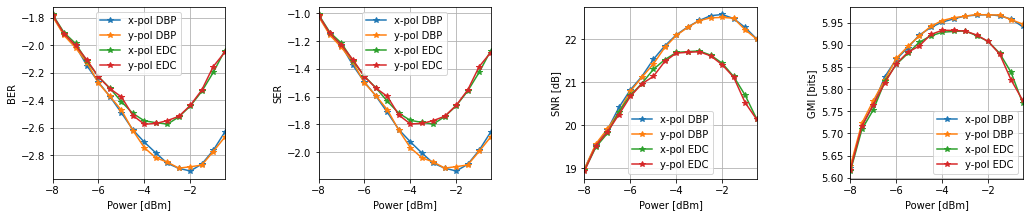

In [8]:
fig, ax = plt.subplots(1,4)
ax[0].plot(Powers, np.log10(BER.T), '-*', label=['x-pol DBP', 'y-pol DBP', 'x-pol EDC', 'y-pol EDC']);
ax[0].set_xlabel('Power [dBm]')
ax[0].set_ylabel('BER')
ax[0].legend()
ax[0].grid()
ax[0].set_box_aspect(1)
ax[0].set_xlim(min(Powers), max(Powers))

ax[1].plot(Powers, np.log10(SER.T), '-*', label=['x-pol DBP', 'y-pol DBP', 'x-pol EDC', 'y-pol EDC']);
ax[1].set_xlabel('Power [dBm]')
ax[1].set_ylabel('SER')
ax[1].legend()
ax[1].grid()
ax[1].set_box_aspect(1)
ax[1].set_xlim(min(Powers), max(Powers))

ax[2].plot(Powers, SNR.T, '-*', label=['x-pol DBP', 'y-pol DBP', 'x-pol EDC', 'y-pol EDC']);
ax[2].set_xlabel('Power [dBm]')
ax[2].set_ylabel('SNR [dB]')
ax[2].legend()
ax[2].grid()
ax[2].set_box_aspect(1)
ax[2].set_xlim(min(Powers), max(Powers))

ax[3].plot(Powers, GMI.T, '-*', label=['x-pol DBP', 'y-pol DBP', 'x-pol EDC', 'y-pol EDC']);
ax[3].set_xlabel('Power [dBm]')
ax[3].set_ylabel('GMI [bits]')
ax[3].legend()
ax[3].grid()
ax[3].set_box_aspect(1)
ax[3].set_xlim(min(Powers), max(Powers))

fig.tight_layout()
fig.set_size_inches(15, 10)